# Initializations


In [18]:
!pip install patchify
!pip install -q -U segmentation_models
%env SM_FRAMEWORK=tf.keras

import tensorflow as tf
import numpy as np
from PIL import Image
import os
from numpy.random import shuffle
import shutil
import patchify as p
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
from matplotlib import cm
import segmentation_models as sm

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [20]:
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

# Hyperparameter Definition

In [21]:
img_w, img_h = 800, 800
win_size = img_w # for tiling

# Optimization params
bs = 8
lr = 1e-3
decay = 0.1
min_lr = 1e-6

# Percentage of tolerated 0 pixel in mask in patches of validation and training
exclude_val = 1.01 # NON TOLERATED
exclude_train = 0.991 # ALL BLACK NON TOLERATED

# freeze encoder: True -> encoder freezed
block_layers = True

apply_data_augmentation = True

mode = "all"
plant = "mais"

BACKBONE = "vgg16"

loss_name = "loss"

# Script Comprehension

Converting in classes


In [22]:
# Converts images to RGB to Target
def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

def mask_to_rgb(mask_arr):

    mask = np.squeeze(mask_arr, axis=2)
    new_mask_arr = np.zeros((mask_arr.shape[0], mask_arr.shape[1], 3), dtype=mask_arr.dtype)

    new_mask_arr[np.where(mask == 0)] = np.array([0, 0, 0])
    new_mask_arr[np.where(mask == 1)] = np.array([255, 255, 255])
    new_mask_arr[np.where(mask == 2)] = np.array([216, 67, 82])

    return new_mask_arr

RLE Encoding

In [23]:
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

Script for dividing training set and validation set. Create .txts.

In [24]:
# plant = 'haricot' OR 'mais' OR 'all'
# mode = 'all' OR 'bipbip' OR 'pead' OR 'roseau' OR 'weedelec'
def split_set(base_dir = './Development_Dataset/Training', split = 0.2, plant = 'haricot', mode = 'all', is_test = False):
    
    plants = []
    
    if plant == 'all':
        plants = ['haricot', 'mais']
    else:
        plants.append(plant)
    
    if not is_test:
      datasets = []
      files_ls = []
    
      if mode == 'all':
          datasets.extend(['Bipbip', 'Pead', 'Roseau', 'Weedelec'])
      else:
          datasets.append(mode.capitalize())
        
      for dataset in datasets:
        for p in plants:
            images_dir = os.path.join(base_dir, dataset, p.capitalize(), 'Images')
            files_ls_temp = os.listdir(images_dir)
            files_ls.extend([filename.split('.')[0] + '\n' for filename in files_ls_temp])
            
      shuffle(files_ls)
          
      final_element = int(len(files_ls) * split)
      val_ls = files_ls[:final_element]
      train_ls = files_ls[final_element:]
      print('# images for training: ' + str(len(train_ls)))
      print('# images for validation: ' + str(len(val_ls)))
          
      with open(os.path.join(base_dir,"train.txt"), "w") as train_txt:
          train_txt.writelines(train_ls)
          
      with open(os.path.join(base_dir,"val.txt"), "w") as val_txt:
          val_txt.writelines(val_ls)
    
    else:

      datasets = []
      datasets.extend(['Bipbip', 'Pead', 'Roseau', 'Weedelec'])

      path = os.path.join(base_dir, "temptest")
      if os.path.exists(path):
        shutil.rmtree(path)
      os.mkdir(path)
    
      plants = ['haricot', 'mais']

      for pl in plants:
        for dataset in datasets:
          images_dir = os.path.join(base_dir, dataset, pl.capitalize(), 'Images')
          files_ls_temp = os.listdir(images_dir)
          for file in files_ls_temp:
            shutil.copy(os.path.join(images_dir, file), path)

Code for tiling

In [25]:
def produce_patches(img_o, mask_o, window_size, step = 20, with_pad = True):
  # From img get array of patches
  # From mask get array of patches
  # window_size = size of a patch
  # step = stride
  # with_pad = Adds pad for precise recostruction

  img_patches = None
  mask_patches = None

  img = None
  mask = None
  pads = None
  if with_pad:
    if img_o is not None:
      # Prepare image in case not proportional step
      diff = np.array([img_o.shape[0] - window_size, img_o.shape[1] - window_size])
      # Since we need exact patches... padding!
      times = np.ceil(diff/step)
      dims = np.multiply([step, step], times)
      pads = window_size+dims-np.array(img_o.shape[:2])
      img = np.pad(img_o, ((0, int(pads[0])), (0, int(pads[1])), (0, 0)), 'constant')
    if mask_o is not None:
      # Prepare image in case not proportional step
      diff = np.array([mask_o.shape[0] - window_size, mask_o.shape[1] - window_size])
      # Since we need exact patches... padding!
      times = np.ceil(diff/step)
      dims = np.multiply([step, step], times)
      pads = window_size+dims-np.array(mask_o.shape[:2])
      mask = np.pad(mask_o, ((0, int(pads[0])), (0, int(pads[1])), (0, 0)), 'constant')
  else:
    img = img_o
    mask = mask_o

  if img is not None:
    img_patches = []
    img_patches_result = p.patchify(img, (window_size, window_size, 3), step=step)
    for w in range(img_patches_result.shape[0]):
      for h in range(img_patches_result.shape[1]):
        img_patches.append(img_patches_result[w, h, 0])
    img_patches = np.array(img_patches)
  if mask is not None:
    mask_patches = []
    mask_patches_result = p.patchify(mask, (window_size, window_size, 1), step=step)
    for w in range(mask_patches_result.shape[0]):
      for h in range(mask_patches_result.shape[1]):
        mask_patches.append(mask_patches_result[w, h, 0])
    mask_patches = np.array(mask_patches)

  return img_patches, mask_patches, pads

def restore_with_interp(img_pa, or_shape, win_size, step, wi, hi):
    #Recostruct from patches
    # or_shape = original shape with len 3
    # win_size = window_size
    # step = step
    # wi = number of patches row wise
    # he = number of patches height wise
    
    i = 0
    margin = win_size - step
    if len(or_shape) == 2:
      raise Exception("or_shape must be 3D")
    result = np.zeros(or_shape, np.float32)

    dtype = img_pa.dtype

    img_p = None
    if dtype != np.float32:
      img_p = img_pa.astype(np.float32)
    else:
      img_p = img_pa

    for w in range(wi):
      for h in range(hi):
        result[w*win_size-w*margin:(w+1)*win_size-w*margin, h*win_size-h*margin:(h+1)*win_size-h*margin] += img_p[i]
        i+=1

    for w in range(wi):
      for h in range(hi):
        if w == 0:
          result[0:margin, step*(h+1):step*(h+1)+margin] /= 2
        result[w*step+margin:(w+1)*step, step*(h+1):step*(h+1)+margin] /= 2

    for h in range(wi):
      for w in range(hi):
        if h == 0:
          result[step*(w+1):step*(w+1)+margin, 0:margin] /= 2
        result[step*(w+1):step*(w+1)+margin, h*step+margin:(h+1)*step] /= 2

    for w in range(1,wi):
      for h in range(1,hi):
        result[win_size*w-margin*w:win_size*w-margin*(w-1), win_size*h-margin*h:win_size*h-margin*(h-1)] /= 4

    if dtype != np.float32:
      result = result.astype(dtype)
      
    return result
  
def reconstruct_patches(img_patches, mask_patches, or_shape, pads, step=20):
  # From img patches get img
  # From mask patches get mask
  # or_shape = [width, height] like of original image
  # step = stride7

  restoring = or_shape
  channel = or_shape[2]
  or_shape = np.uint(np.array(or_shape[:2]) + pads)
  or_shape = [or_shape[0], or_shape[1], channel]

  # Values for restoration
  win_size = img_patches.shape[1]
  
  img = None
  mask = None
  if img_patches is not None:
    wh = img_patches.shape[0]
    wi = int((or_shape[0] - img_patches.shape[1])//step + 1)
    he = int((or_shape[1] - img_patches.shape[2])//step + 1)
    if wh != he * wi:
      raise Exception("hw != h*w")
    
    img = restore_with_interp(img_patches, or_shape, win_size, step, wi, he)
    img = img[:restoring[0],:restoring[1]]

  if mask_patches is not None:
    wh = mask_patches.shape[0]
    wi = int((or_shape[0] - mask_patches.shape[1])//step + 1)
    he = int((or_shape[1] - mask_patches.shape[2])//step + 1)
    if wh != hi * we:
      raise Exception("hw != h*w")
      
    mask = restore_with_interp(mask_patches, or_shape, win_size, step, wi, he)
    mask = mask[:restoring[0],:restoring[1]]
  return img, mask

Code used for counting number of pixel in mask. Optimized to be fast. 

In [26]:
# Return a dictionary of distinct values of mask
def f_pp(mask, nmax=1000):
    iai32 = mask.ravel()
    colors = list(set(iai32))
    counts = []
    match = None
    for i in range(0, len(colors)):
        counts.append(0)
        match = iai32 == colors[i]
        counts[i] = np.count_nonzero(match)
    colors = [np.uint8(col) for col in colors]
    return {a[0] : a[1] for a in zip(colors, counts)}

Utility script to save the patch in a folder and having them swiftly prepared

In [27]:
def save_patch(save_fld, sub, dat_dir, win_size, exclude = 0.95):
  # This method create patches for entire dataset and save it in a folder
  # A text file with all the images is also created.

  subset_file = None
  if sub == 'training':
      subset_file = os.path.join(dat_dir, 'train.txt')
  elif sub == 'validation':
      subset_file = os.path.join(dat_dir, 'val.txt')
    
  with open(subset_file, 'r') as f:
    lines = f.readlines()
    
  subset_filenames = []
  for line in lines:
    subset_filenames.append(line.strip())
  
  image_names = []
  folder = "Images"
  folder_m = "Masks"

  if os.path.exists(save_fld):
    shutil.rmtree(save_fld)
  os.makedirs(save_fld)
  os.makedirs(os.path.join(save_fld, folder))
  os.makedirs(os.path.join(save_fld, folder_m))
  
  for i in range(0, len(subset_filenames)):
    curr_filename = subset_filenames[i]
    split_filename = curr_filename.split('_')
    curr_dataset = split_filename[0]
    curr_plant = split_filename[1]
    
    if curr_dataset == 'Roseau':
        img = Image.open(os.path.join(dat_dir, curr_dataset, curr_plant.capitalize(), 'Images',
                                      curr_filename + '.png'))
    else:
        img = Image.open(os.path.join(dat_dir, curr_dataset, curr_plant.capitalize(), 'Images',
                                      curr_filename + '.jpg'))
    
    mask = Image.fromarray(read_rgb_mask(os.path.join(dat_dir, curr_dataset, curr_plant.capitalize(),
                                                      'Masks', curr_filename + '.png')))

    img_arr = np.array(img)
    mask_arr = np.array(mask)
    mask_arr = np.expand_dims(mask_arr, -1)
    
    # We put WITH_PAD = FALSE in order to avoid creating overlapping images in training.
    # This is done because introducing overlapping images would cause redundancy.
    img_p, mask_p, _ = produce_patches(img_arr, mask_arr, win_size, step=win_size, with_pad=False)
    img_arr = []
    mask_arr = []
    sum = win_size*win_size
    for j in range(0, mask_p.shape[0]):
      dict_colors = f_pp(mask_p[j])
      if dict_colors.get(0, 0) < sum*exclude:
         filename = "img_" + str(len(image_names)) + ".png"
         img = Image.fromarray(img_p[j])
         mask = Image.fromarray(mask_to_rgb(mask_p[j]))
         img.save(os.path.join(save_fld, folder, filename))
         mask.save(os.path.join(save_fld, folder_m, filename))
         image_names.append(filename + '\n')
    print(i+1, "images processed. Still: ", len(subset_filenames)-i-1)
  with open(os.path.join(save_fld,"img.txt"), "w") as val_txt:
    val_txt.writelines(image_names)

Code for plotting data

In [28]:
def plot_hist(hist):
    plt.plot(hist.history["iou_score"])
    plt.plot(hist.history["val_iou_score"])
    plt.plot(hist.history[loss_name])
    plt.plot(hist.history["val_" + loss_name])
    plt.title("model IoU")
    plt.ylabel("score")
    plt.xlabel("epoch")
    plt.legend(["train_IoU", "val_IoU", loss_name, "val_" + loss_name], loc="upper left")
    plt.show()

# Data Preparation

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
if not os.path.exists(dataset_dir):
  !unzip -q '/content/drive/My Drive/Development_Dataset.zip'

In [38]:
cwd = './'

dataset_dir = "Dataset"
training_dir = os.path.join(dataset_dir, "Training")
test_dir = os.path.join(dataset_dir, "Test_Dev")

In [39]:
# Split train and validation sets
split_set(base_dir= training_dir, mode=mode, plant=plant)

# images for training: 288
# images for validation: 72


In [40]:
# Create and save patches (if not already created)
path_val = os.path.join(dataset_dir, "Training", "Patches", "Subdivided_val", mode, plant, str(win_size))
path_train = os.path.join(dataset_dir, "Training", "Patches", "Subdivided", mode, plant, str(win_size))

if not os.path.exists(path_train):
  save_patch(path_train, 'training', training_dir, win_size=win_size, exclude=exclude_train)
if not os.path.exists(path_val):
  save_patch(path_val, 'validation', training_dir, win_size=win_size, exclude=exclude_val) # Do not exclude anything

1 images processed. Still:  287
2 images processed. Still:  286
3 images processed. Still:  285
4 images processed. Still:  284
5 images processed. Still:  283
6 images processed. Still:  282
7 images processed. Still:  281
8 images processed. Still:  280
9 images processed. Still:  279
10 images processed. Still:  278
11 images processed. Still:  277
12 images processed. Still:  276
13 images processed. Still:  275
14 images processed. Still:  274
15 images processed. Still:  273
16 images processed. Still:  272
17 images processed. Still:  271
18 images processed. Still:  270
19 images processed. Still:  269
20 images processed. Still:  268
21 images processed. Still:  267
22 images processed. Still:  266
23 images processed. Still:  265
24 images processed. Still:  264
25 images processed. Still:  263
26 images processed. Still:  262
27 images processed. Still:  261
28 images processed. Still:  260
29 images processed. Still:  259
30 images processed. Still:  258
31 images processed

Dictionary with array colors, used for visualization

In [41]:
dict_rgb = {
    "background" : [254, 124, 18],
    "crop" : [255, 255, 255],
    "weed" : [216, 67, 82]
}

Generator for creating imgs from patch dataset

In [42]:
# Patches Generator
class create_generator(tf.keras.utils.Sequence):

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None):
    subset_file = os.path.join(dataset_dir, 'img.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    return self.__data__generation(index)
        
  def __data__generation(self, index):
    
    if index >= len(self.subset_filenames):
      return None, None
    curr_filename = self.subset_filenames[index]
    
    img = Image.open(os.path.join(self.dataset_dir, 'Images',
                                      curr_filename))
    mask = Image.fromarray(read_rgb_mask(os.path.join(self.dataset_dir, 'Masks',
                                      curr_filename)))

    img_arr = np.array(img)
    mask_arr = np.array(mask)
    
    if len(mask_arr.shape) == 2: 
      mask_arr = np.expand_dims(mask_arr, -1)

    out_mask = None

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        
        # No SEED because it would generate the same transformation at every epoch
        img_t = self.img_generator.get_random_transform(img_arr.shape)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, img_t)
            
            curr_class_arr = np.uint8(curr_class_arr)
            
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)
      
    return img_arr, np.float32(out_mask)

Generators and Datasets

In [43]:
preprocess_input = None

# Create training ImageDataGenerator object
# The commented transformations seemed to hurt performance
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(# rotation_range=10,
                                      # width_shift_range=10,
                                      # height_shift_range=10,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(# rotation_range=10,
                                       # width_shift_range=10,
                                       # height_shift_range=10,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')
else:
    img_data_gen = ImageDataGenerator()
    mask_data_gen = ImageDataGenerator()

In [44]:
train_gen = create_generator(path_train, 'training', 
                          img_generator=img_data_gen, 
                          mask_generator=mask_data_gen,
                          preprocessing_function = preprocess_input)
valid_gen = create_generator(path_val, 'validation',
                          preprocessing_function = preprocess_input)

train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

Visualize image and mask to be sure that all works well

(800, 800, 3) (8, 800, 800, 1)
[0. 2.]


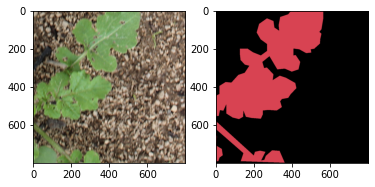

In [45]:
iterator = iter(train_dataset)

fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]
augmented_img = augmented_img

print(augmented_img.shape, target.shape)
target = np.array(target[0, ..., 0])

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]

class_names = ["background", "crop", "weed"]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(dict_rgb[class_names[i]])

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

## Convolutional Neural Network (CNN)
### Encoder-Decoder

Preparing model

In [46]:
# Paper https://ieeexplore.ieee.org/document/8460962
import tensorflow as tf
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

def residual_block(input_layer, filters = 8):
  conv1 = tf.keras.layers.Conv2D(filters = filters, kernel_size=[1, 1], activation="relu", padding="same")(input_layer)
  conv2 = tf.keras.layers.Conv2D(filters = filters, kernel_size=[5, 1], activation="relu", padding="same")(conv1)
  conv3 = tf.keras.layers.Conv2D(filters = filters, kernel_size=[1, 5], activation="relu", padding="same")(conv2)
  conv4 = tf.keras.layers.Conv2D(filters = filters*2, kernel_size=[1, 1], activation="relu", padding="same")(conv3)
  conc = tf.keras.layers.Add()([conv4, input_layer])
  return conc

def convo_block(input_layer, filter = 16):
  return tf.keras.layers.Conv2D(filters = 16, kernel_size=[5,5], activation="relu", padding="same")(input_layer)

class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        ksize = [1, pool_size[0], pool_size[1], 1]
        padding = padding.upper()
        strides = [1, strides[0], strides[1], 1]
        output, argmax = tf.nn.max_pool_with_argmax(
                inputs, ksize=ksize, strides=strides, padding=padding
            )
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx] if dim is not None else None
            for idx, dim in enumerate(input_shape)
        ]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]

class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.compat.v1.variable_scope(self.name):
            mask = tf.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')
            #print(updates.shape)
            #print(mask.shape)
            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3])

            ret = tf.scatter_nd(K.expand_dims(K.flatten(mask)),
                                  K.flatten(updates),
                                  [K.prod(output_shape)])

            input_shape = updates.shape
            out_shape = [-1,
                        input_shape[1] * self.size[0],
                        input_shape[2] * self.size[1],
                        input_shape[3]]
        return tf.reshape(ret, out_shape)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'size': self.size
        })
        return config

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

def pooling_block(input_layer):
   pool, mask = MaxPoolingWithArgmax2D((2,2))(input_layer)
   return pool, mask

def unpooling_block(input, mask):
   return MaxUnpooling2D((2,2))([input, mask])

def network(input_shape = (512, 512)):
  # encoder
  input = tf.keras.layers.Input(shape=(input_shape[0], input_shape[1], 3))
  conv1 = convo_block(input)
  res1 = residual_block(conv1)
  res2 = residual_block(res1)
  res3 = residual_block(res2)

  pool1, mask1 = pooling_block(res3)

  res4 = residual_block(pool1)
  res5 = residual_block(res4)
  res6 = residual_block(res5)

  pool2, mask2 = pooling_block(res6)

  res7 = residual_block(pool2)
  res8 = residual_block(res7)
  res9 = residual_block(res8)

  pool3, mask3 = pooling_block(res9)

  res10 = residual_block(pool3)
  res11 = residual_block(res10)
  res12 = residual_block(res11)

  pool4, mask4 = pooling_block(res12)

  # Encoder

  unp1 = unpooling_block(pool4, mask4)

  res13 = residual_block(unp1)
  res14 = residual_block(res13)
  res15 = residual_block(res14)

  unp2 = unpooling_block(res15, mask3)

  res16 = residual_block(unp2)
  res17 = residual_block(res16)
  res18 = residual_block(res17)

  unp3 = unpooling_block(res18, mask2)

  res19 = residual_block(unp3)
  res20 = residual_block(res19)
  res21 = residual_block(res20)

  unp4 = unpooling_block(res21, mask1)

  res22 = residual_block(unp4)
  res23 = residual_block(res22)
  res24 = residual_block(res23)

  output_layer = tf.keras.layers.Conv2D(filters = 3, kernel_size=[1, 1], activation="softmax")(res24)
  return tf.keras.Model(inputs=input, outputs=output_layer, name="Paper")
model = network(input_shape = (img_w, img_h))
model.summary()

Model: "Paper"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 800, 800, 3) 0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 800, 800, 16) 1216        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 800, 800, 8)  136         conv2d_98[0][0]                  
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 800, 800, 8)  328         conv2d_99[0][0]                  
______________________________________________________________________________________________

In [47]:
model = network(input_shape = (img_w, img_h))
model.summary()

Model: "Paper"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 800, 800, 3) 0                                            
__________________________________________________________________________________________________
conv2d_196 (Conv2D)             (None, 800, 800, 16) 1216        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_197 (Conv2D)             (None, 800, 800, 8)  136         conv2d_196[0][0]                 
__________________________________________________________________________________________________
conv2d_198 (Conv2D)             (None, 800, 800, 8)  328         conv2d_197[0][0]                 
______________________________________________________________________________________________

Dice Coefficient as Loss Function

In [48]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-8) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-8)

def dice_loss(y_true, y_pred):
    dice=0
    y_true = tf.squeeze(y_true, -1)
    for index in range(1, 3):
        dice -= dice_coef(tf.cast(tf.where(y_true == index, 1, 0), tf.float32), tf.cast(y_pred[:,:,:,index], tf.float32))
    return dice

Losses, Metrics and Optimizer

In [49]:
# Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy()

IOUmetric = sm.metrics.IOUScore()

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

metrics = ['accuracy', IOUmetric]

In [50]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Callbacks

In [52]:
import os
from datetime import datetime

net = BACKBONE

callbacks = []

exps_dir = os.path.join(cwd, 'Training', 'Checkpoints', 'multiclass_segmentation_experiments' + net)
if not os.path.exists(exps_dir):
  os.makedirs(exps_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(exps_dir, 'weights'), 
                                                   save_weights_only=True, save_best_only=True)  # False to save the model directly

callbacks.append(ckpt_callback)

# Early Stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode='min')
callbacks.append(es_callback)

# Decay on Plateau
decay_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=decay, patience=5, verbose=1,
    mode='min', min_lr=min_lr)
callbacks.append(decay_callback)

# Training

In [ ]:
hist = model.fit(x=train_dataset,
                 epochs=100,
                 steps_per_epoch=len(train_gen)//bs,
                 validation_data=valid_dataset,
                 validation_steps=len(valid_gen)//bs,
                 callbacks=callbacks)

Epoch 1/100
 17/195 [=>............................] - ETA: 2:06:05 - loss: 4.7906 - accuracy: 0.7640 - iou_score: 0.1176

In [ ]:
plot_hist(hist)

# Prediction

In [ ]:
# First create the generator for the test_set

# Step = stride of patches
# Set step = win_size-4 to create patches with an overlapping border of width = 4
step = win_size-4

split_set(base_dir=test_dir, is_test = True)
temptest = os.path.join(test_dir, "temptest")

images = os.listdir(temptest)
submission_dict = {}

net = BACKBONE
exps_dir = os.path.join(cwd, 'Training', 'Checkpoints', 'multiclass_segmentation_experiments' + net)
filepath = os.path.join(exps_dir, 'weights')

model.load_weights(filepath)

if len(images) > 0:
  idx = 0
  for img_name in images:

    imgs = Image.open(os.path.join(temptest, img_name))
    img_arr = np.array(imgs)
    or_shape = img_arr.shape

    predictions_m = []
    
    # pads is the number of pixels added to the original image for zero-padding.
    # Needed to obtain an integer number of patches.
    # The padding is removed for the final prediction.
    img_p, _, pads = produce_patches(img_arr, None, win_size, step = step)
  
    for i in range(img_p.shape[0]):
        out_sigmoid = model.predict(x=tf.expand_dims(img_p[i], axis=0))
        predictions_m.append(out_sigmoid)

    predictions_m = np.concatenate(predictions_m, axis = 0)
    # Only replace step
    predicted_class, _ = reconstruct_patches(predictions_m, None, or_shape, pads, step=step)
    print(predicted_class.shape)
    # Get predicted class as the index corresponding to the maximum value in the vector probability
    # predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
    # predicted_class = predicted_class[0, ..., 0]
    predicted_class = tf.argmax(predicted_class, -1)
    mask_arr = predicted_class
    mask_arr = np.array(mask_arr)

    plt.show()

    split_filename = img_name.split('_')
    curr_dataset = split_filename[0]
    curr_plant = split_filename[1]
    curr_plant = curr_plant.capitalize()

    img_name = os.path.splitext(img_name)
    img_name = img_name[0]

    submission_dict[img_name] = {}
    submission_dict[img_name]['shape'] = or_shape
    submission_dict[img_name]['team'] = curr_dataset
    submission_dict[img_name]['crop'] = curr_plant
    submission_dict[img_name]['segmentation'] = {}

    # RLE encoding
    # crop
    rle_encoded_crop = rle_encode(mask_arr == 1)
    # weed
    rle_encoded_weed = rle_encode(mask_arr == 2)

    submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
    submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed


# Finally, save the results into the submission.json file
import json
with open('submission.json', 'w') as f:
    json.dump(submission_dict, f)

In [ ]:
import zipfile
zipfile.ZipFile('submission.zip', mode='w').write("submission.json")